<a href="https://colab.research.google.com/github/ParitKansal/ReinforcementLearning/blob/main/RL_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import numpy as np # For numerical operations (like mean)
import matplotlib.pyplot as plt # For plotting results
import random # For random choices (exploration, tie-breaking)
from collections import defaultdict # Convenient for creating nested dictionaries for memory
from typing import Tuple, Dict, List, DefaultDict, Any # For type hinting

# Set random seeds for reproducibility
seed: int = 42
random.seed(seed)
np.random.seed(seed)

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

print("Libraries imported and seeds set.")

Libraries imported and seeds set.


In [2]:
class Environment:
    def __init__(self, rows: int = 15, cols: int = 15):
        # Grid size (rows x cols)
        self.rows: int = rows
        self.cols: int = cols

        # Define start and goal positions
        self.start_state: Tuple[int, int] = (0, 0)
        self.goal_state: Tuple[int, int] = (self.rows - 1, self.cols - 1)

        # Current agent position
        self.curr_state: Tuple[int, int] = self.start_state

        # Action map: maps action string -> (row_change, col_change)
        self.action_map: Dict[str, Tuple[int, int]] = {
            "up": (-1, 0),
            "down": (1, 0),
            "left": (0, -1),
            "right": (0, 1)
        }

        # Rewards
        self.wall_hitting_reward: float = -1.0   # penalty for hitting wall
        self.default_reward: float = -0.1        # small negative reward per step
        self.goal_reward: float = 10.0           # reward for reaching the goal

    # -------------------
    # Public methods (user-facing)
    # -------------------

    def reset(self) -> Tuple[int, int]:
        """Reset the environment to the starting position."""
        self.curr_state = self.start_state
        return self.curr_state

    def step(self, action: str):
        """
        Take one step in the environment based on the given action.
        Updates current state.
        Returns:
            next_state (Tuple[int, int]), reward (float), done (bool)
        """
        # If already at goal, return terminal state
        if self.curr_state == self.goal_state:
            return self.curr_state, 0.0, True

        # Compute next state and reward using private helpers
        next_state = self._compute_next_state(self.curr_state, action)
        reward = self._compute_reward(self.curr_state, action)

        # Check if goal reached
        done = (next_state == self.goal_state)

        # Update current state
        self.curr_state = next_state
        return next_state, reward, done

    def action_space(self) -> List[str]:
        """Return the list of all possible actions."""
        return list(self.action_map.keys())

    def state_space(self) -> List[Tuple[int, int]]:
        """Return the list of all possible states."""
        return [(r, c) for r in range(self.rows) for c in range(self.cols)]

    # -------------------
    # Private helper methods
    # -------------------

    def _compute_next_state(self, state: Tuple[int, int], action: str) -> Tuple[int, int]:
        """Internal helper: compute next state without modifying environment."""
        if action not in self.action_map:
            raise ValueError(f"Unknown action: {action}")

        row_change, col_change = self.action_map[action]
        next_row = state[0] + row_change
        next_col = state[1] + col_change

        # If action goes outside grid, agent stays in the same place
        if not (0 <= next_row < self.rows and 0 <= next_col < self.cols):
            return state
        else:
            return (next_row, next_col)

    def _compute_reward(self, state: Tuple[int, int], action: str) -> float:
        """Internal helper: compute reward for state-action pair."""
        next_state = self._compute_next_state(state, action)

        if next_state == self.goal_state:
            return self.goal_reward
        elif next_state == state and state != self.goal_state:  # wall hit
            return self.wall_hitting_reward
        else:
            return self.default_reward

In [3]:
class SARSAAgent:
    """
    Tabular SARSA agent (on-policy).
    Update rule:
        Q(s,a) <- Q(s,a) + alpha * (reward + gamma * Q(s', a') - Q(s,a))
    If next state is terminal, the target is just the reward.
    """
    def __init__(self,
                 state_space: List[Tuple[int, int]],
                 action_space: List[str],
                 alpha: float = 0.2,
                 gamma: float = 0.99,
                 epsilon_start: float = 1.0,
                 epsilon_end: float = 0.01,
                 decay_rate: float = 0.999,
                 seed: int | None = None):
        self.state_space = state_space
        self.action_space = action_space
        self.alpha = alpha
        self.gamma = gamma

        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.decay_rate = decay_rate
        self.epsilon = epsilon_start

        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)

        # initialize q-table: state -> {action: qvalue}
        self.q_table: Dict[Tuple[int, int], Dict[str, float]] = {}
        for s in state_space:
            self.q_table[s] = {a: 0.0 for a in action_space}

    def reset(self) -> None:
        """Reset agent memory (zero Q-table and reset epsilon)."""
        for s in self.state_space:
            self.q_table[s] = {a: 0.0 for a in self.action_space}
        self.epsilon = self.epsilon_start

    def choose_action(self, state: Tuple[int, int]) -> str:
        """Epsilon-greedy action selection with random tie-breaking for argmax."""
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_space)
        # exploitation: choose action(s) with max Q, break ties randomly
        action_values = self.q_table[state]
        max_val = max(action_values.values())
        best_actions = [a for a, v in action_values.items() if v == max_val]
        return np.random.choice(best_actions)

    def update(self,
               state: Tuple[int, int],
               action: str,
               reward: float,
               next_state: Tuple[int, int],
               next_action: str | None,
               done: bool) -> None:
        """
        SARSA update:
           current_q = Q(s,a)
           if done (terminal): target = reward
           else: target = reward + gamma * Q(next_state, next_action)
           Q(s,a) <- current_q + alpha * (target - current_q)
        next_action can be None when done=True (we'll ignore Q(next_state, next_action) then).
        """
        current_q = self.q_table[state][action]
        if done:
            target = reward
        else:
            next_q = self.q_table[next_state][next_action]
            target = reward + self.gamma * next_q

        td_error = target - current_q
        self.q_table[state][action] = current_q + self.alpha * td_error

    def decay_epsilon(self) -> None:
        """Decay epsilon multiplicatively and enforce floor epsilon_end."""
        self.epsilon = max(self.epsilon_end, self.epsilon * self.decay_rate)

    def get_q(self, state: Tuple[int, int], action: str) -> float:
        return self.q_table[state][action]

    def get_policy(self) -> Dict[Tuple[int, int], str]:
        """Return deterministic greedy policy (best action for each state)."""
        policy = {}
        for s in self.state_space:
            action_values = self.q_table[s]
            max_val = max(action_values.values())
            best_actions = [a for a, v in action_values.items() if v == max_val]
            policy[s] = np.random.choice(best_actions)
        return policy

In [4]:
env = Environment()
agent = SARSAAgent(state_space=env.state_space(),
                   action_space=env.action_space(),
                   alpha=0.3,
                   gamma=0.95,
                   epsilon_start=1.0,
                   epsilon_end=0.01,
                   decay_rate=0.995,
                   seed=42)

NUM_EPISODES = 1500
MAX_STEPS = 150

episode_rewards = []
steps_length = []
successes = 0
epsilons = []

for ep in range(1, NUM_EPISODES + 1):
    epsilons.append(agent.epsilon)
    state = env.reset()
    done = False
    total_reward = 0.0

    # For SARSA we must choose the first action from the current policy
    action = agent.choose_action(state)

    for t in range(MAX_STEPS):
        next_state, reward, done = env.step(action)
        total_reward += reward

        if done:
            # terminal: pass next_action=None and done=True
            agent.update(state, action, reward, next_state, None, done=True)
            successes += 1
            steps_length.append(t + 1)
            break
        else:
            # choose next action according to current policy (on-policy)
            next_action = agent.choose_action(next_state)
            # update with next_action
            agent.update(state, action, reward, next_state, next_action, done=False)

            # move to next state-action
            state = next_state
            action = next_action
    else:
        # didn't break (no success)
        steps_length.append(MAX_STEPS)

    episode_rewards.append(total_reward)
    agent.decay_epsilon()

    # print periodic stats (same style as your original)
    if ep % 100 == 0 or ep == 1:
        avg_reward = np.mean(episode_rewards[-500:]) if len(episode_rewards) >= 1 else float("nan")
        success_rate = successes / ep
        avg_steps = np.mean(steps_length[-500:]) if len(steps_length) >= 1 else float("nan")
        print(f"Episode {ep:4d} | avg_reward(last500) {avg_reward:.3f} | success_rate {success_rate:.3f} | epsilon {agent.epsilon:.3f} | avg_steps(last500) {avg_steps:.1f}")

Episode    1 | avg_reward(last500) -34.800 | success_rate 0.000 | epsilon 0.995 | avg_steps(last500) 150.0
Episode  100 | avg_reward(last500) -18.133 | success_rate 0.250 | epsilon 0.606 | avg_steps(last500) 139.3
Episode  200 | avg_reward(last500) -10.098 | success_rate 0.565 | epsilon 0.367 | avg_steps(last500) 115.4
Episode  300 | avg_reward(last500) -5.390 | success_rate 0.710 | epsilon 0.222 | avg_steps(last500) 94.9
Episode  400 | avg_reward(last500) -2.537 | success_rate 0.782 | epsilon 0.135 | avg_steps(last500) 80.6
Episode  500 | avg_reward(last500) -0.682 | success_rate 0.826 | epsilon 0.082 | avg_steps(last500) 70.8
Episode  600 | avg_reward(last500) 4.356 | success_rate 0.855 | epsilon 0.049 | avg_steps(last500) 48.9
Episode  700 | avg_reward(last500) 6.201 | success_rate 0.876 | epsilon 0.030 | avg_steps(last500) 36.5
Episode  800 | avg_reward(last500) 6.833 | success_rate 0.891 | epsilon 0.018 | avg_steps(last500) 31.4
Episode  900 | avg_reward(last500) 7.079 | success_r

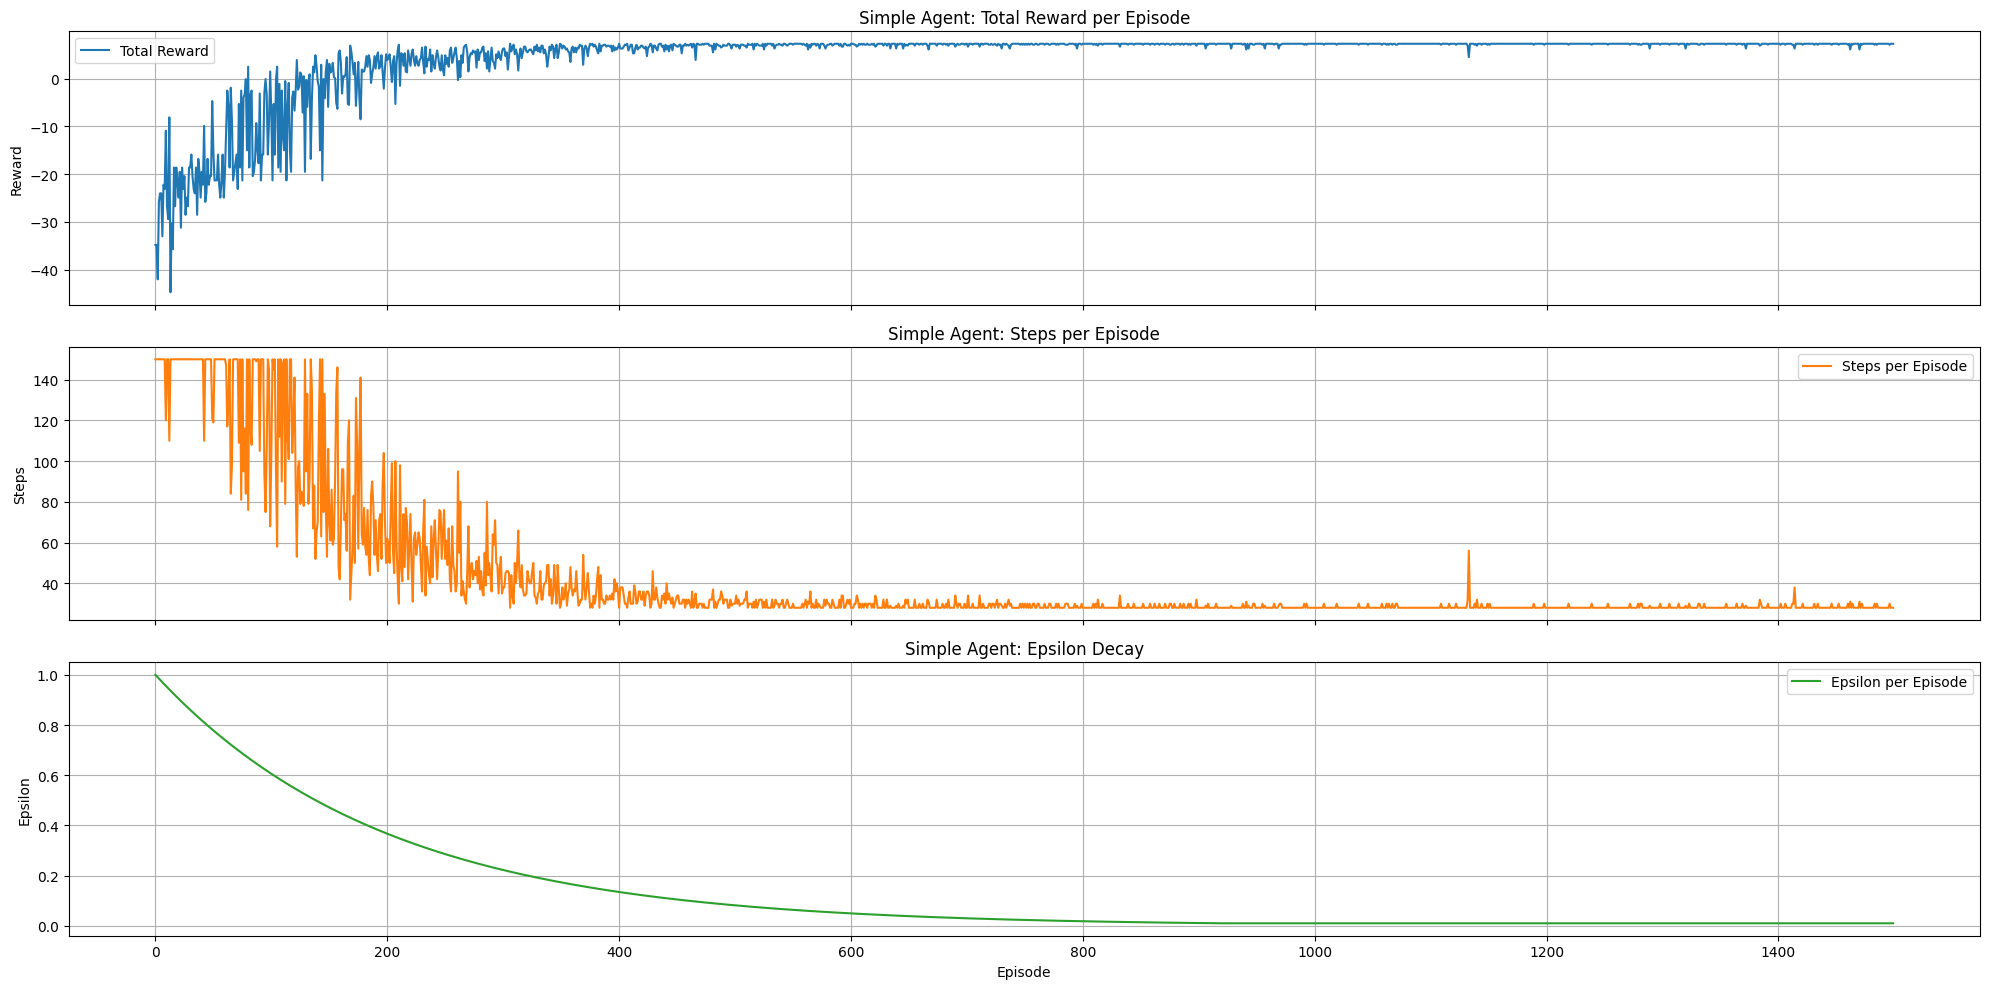

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(20, 10), sharex=True)

# --- Rewards ---
axes[0].plot(episode_rewards, label='Total Reward', color='tab:blue')
axes[0].set_title('Simple Agent: Total Reward per Episode')
axes[0].set_ylabel('Reward')
axes[0].grid(True)
axes[0].legend()

# --- Steps ---
axes[1].plot(steps_length, label='Steps per Episode', color='tab:orange')
axes[1].set_title('Simple Agent: Steps per Episode')
axes[1].set_ylabel('Steps')
axes[1].grid(True)
axes[1].legend()

# --- Epsilon ---
axes[2].plot(epsilons, label='Epsilon per Episode', color='tab:green')
axes[2].set_title('Simple Agent: Epsilon Decay')
axes[2].set_xlabel('Episode')
axes[2].set_ylabel('Epsilon')
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()

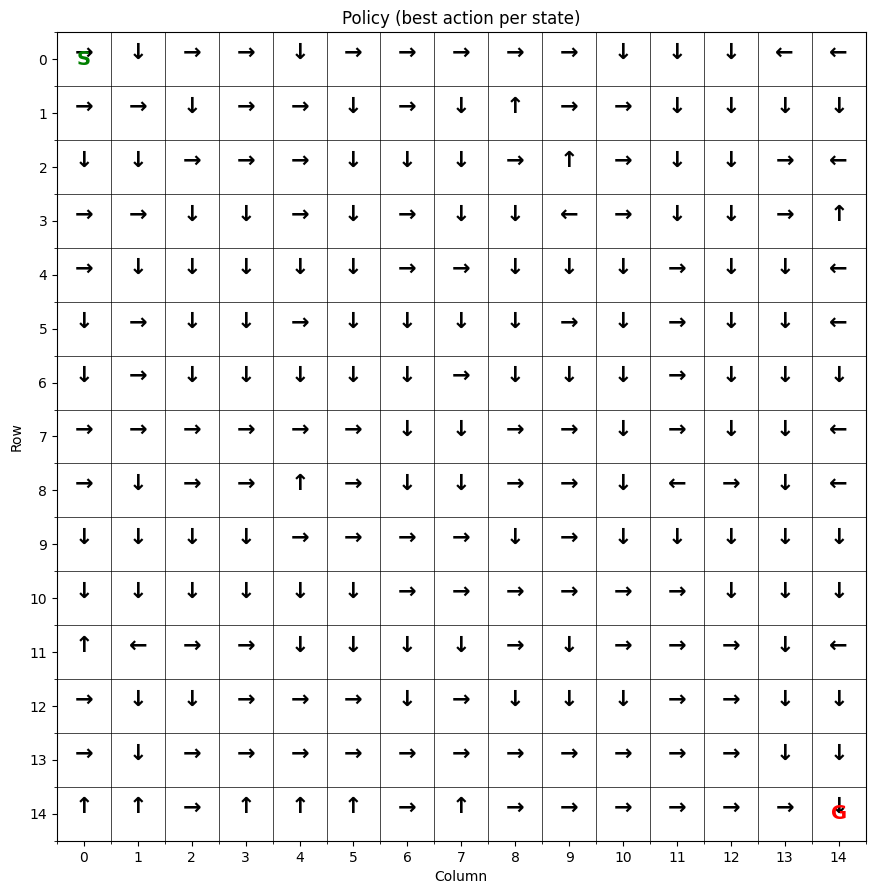

In [6]:
def plot_policy_from_policy_dict(policy: Dict[Tuple[int,int], str],
                                 env: Environment,
                                 figsize_per_cell: float = 0.7) -> None:
    """
    Plot a policy dict where policy[(r,c)] -> action string ("up","down","left","right").
    Row 0 is shown at the top (rows top->bottom).
    """
    rows, cols = env.rows, env.cols
    fig, ax = plt.subplots(figsize=(cols * figsize_per_cell, rows * figsize_per_cell))

    # light background grid
    ax.imshow(np.zeros((rows, cols)), cmap="Greys", alpha=0.12, origin="upper")

    # draw arrows / symbols
    arrow_map = {"up": "↑", "down": "↓", "left": "←", "right": "→"}
    for r in range(rows):
        for c in range(cols):
            a = policy.get((r, c), None)
            sym = arrow_map.get(a)
            ax.text(c, r - 0.12, sym, ha="center", va="center", fontsize=16, fontweight="bold")

    # Mark Start and Goal (x=col, y=row)
    sr, sc = env.start_state
    gr, gc = env.goal_state
    ax.text(sc, sr, "S", ha="center", va="center", color="green", fontsize=14, fontweight="bold")
    ax.text(gc, gr, "G", ha="center", va="center", color="red", fontsize=14, fontweight="bold")

    # grid lines and axes
    ax.set_xticks(np.arange(cols))
    ax.set_yticks(np.arange(rows))
    ax.set_xticks(np.arange(-.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-.5, rows, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
    ax.set_xlim(-0.5, cols - 0.5)
    ax.set_ylim(rows - 0.5, -0.5)  # keep row 0 at top
    ax.set_title("Policy (best action per state)")
    ax.set_xlabel("Column")
    ax.set_ylabel("Row")
    plt.show()


policy = agent.get_policy()
plot_policy_from_policy_dict(policy, env, figsize_per_cell=0.7)

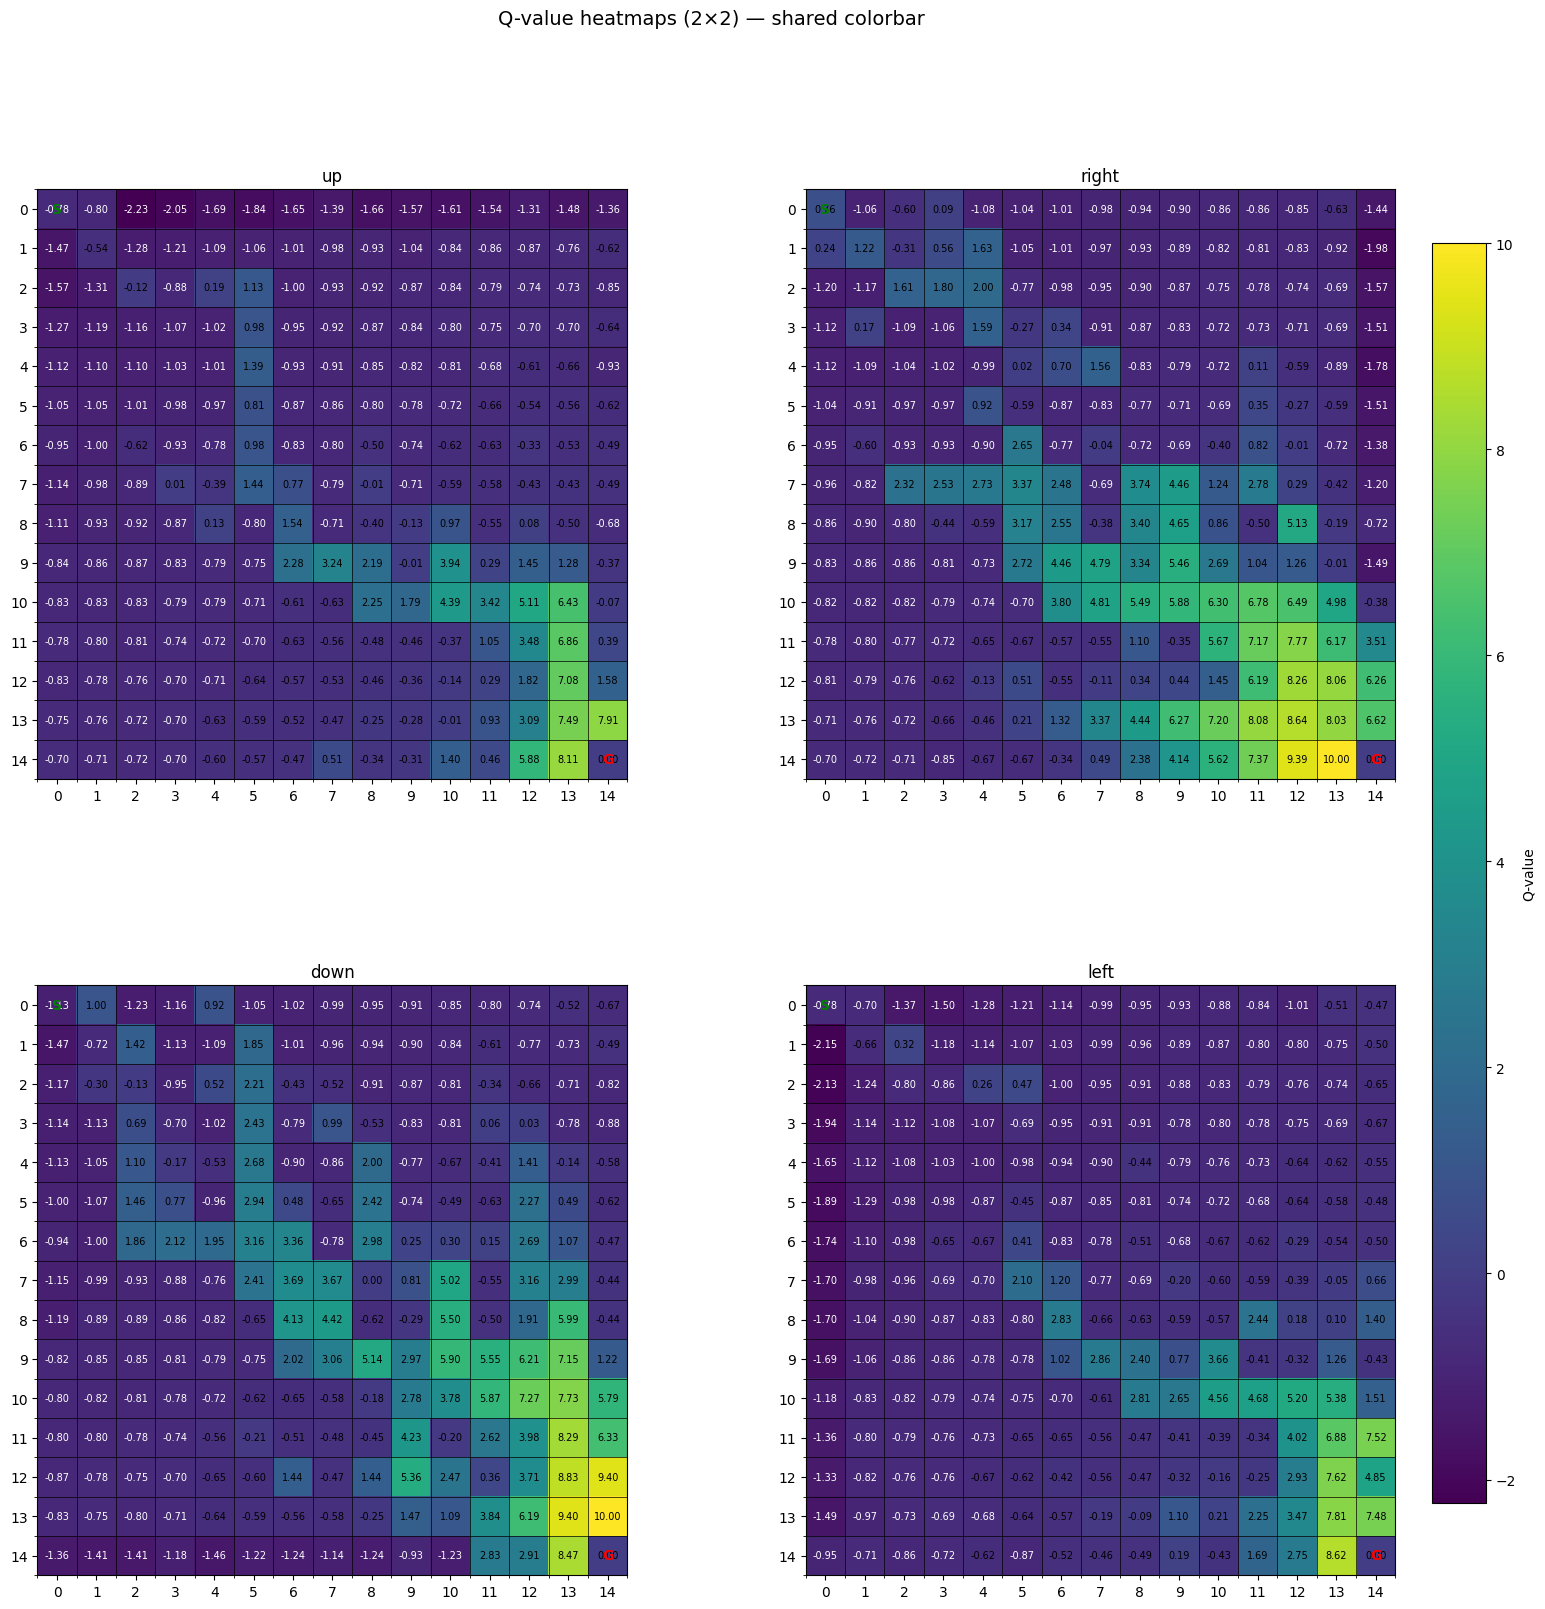

In [7]:
def plot_q_heatmaps_2x2_shared_colorbar(agent, env,
                                        actions=("up", "right", "down", "left"),
                                        figsize_per_cell: float = 0.6):
    rows, cols = env.rows, env.cols
    n_actions = len(actions)
    assert n_actions == 4, "This function assumes exactly 4 actions for a 2x2 layout."

    # --- Prepare q_grids for all actions first, so we can compute global vmin/vmax ---
    q_grids = []
    for action in actions:
        q_grid = np.full((rows, cols), np.nan)
        for r in range(rows):
            for c in range(cols):
                state = (r, c)
                action_dict = agent.q_table.get(state, {})
                q_grid[r, c] = action_dict.get(action, np.nan)
        q_grids.append(q_grid)

    # compute global vmin/vmax across all grids (ignore NaNs)
    try:
        vmin = float(np.nanmin(np.stack(q_grids)))
        vmax = float(np.nanmax(np.stack(q_grids)))
    except ValueError:
        # all NaNs fallback
        vmin, vmax = 0.0, 1.0

    # avoid vmin==vmax (matplotlib will complain); expand slightly if equal
    if np.isclose(vmin, vmax):
        vmin -= 1e-6
        vmax += 1e-6

    # global median for annotation color contrast
    global_median = float(np.nanmedian(np.stack(q_grids)))

    # --- Create 2x2 subplots ---
    fig, axes = plt.subplots(2, 2,
                             figsize=(cols * figsize_per_cell * 2, rows * figsize_per_cell * 2))
    axes = axes.flatten()

    ims = []
    for ax, action, q_grid in zip(axes, actions, q_grids):
        im = ax.imshow(q_grid, origin="upper", aspect="equal", vmin=vmin, vmax=vmax)
        ims.append(im)

        # Annotate numeric values
        for r in range(rows):
            for c in range(cols):
                val = q_grid[r, c]
                if not np.isnan(val):
                    txt_color = "white" if val < global_median else "black"
                    ax.text(c, r, f"{val:.2f}", ha="center", va="center", fontsize=7, color=txt_color)

        # Mark Start & Goal (x=col, y=row)
        sr, sc = env.start_state
        gr, gc = env.goal_state
        ax.text(sc, sr, "S", ha="center", va="center", color="green", fontsize=10, fontweight="bold")
        ax.text(gc, gr, "G", ha="center", va="center", color="red", fontsize=10, fontweight="bold")

        # Grid lines and ticks
        ax.set_xticks(np.arange(cols))
        ax.set_yticks(np.arange(rows))
        ax.set_xticks(np.arange(-.5, cols, 1), minor=True)
        ax.set_yticks(np.arange(-.5, rows, 1), minor=True)
        ax.grid(which="minor", color="black", linestyle="-", linewidth=0.5)
        ax.set_xlim(-0.5, cols - 0.5)
        ax.set_ylim(rows - 0.5, -0.5)
        ax.set_title(action)

    # --- Shared colorbar on its own axis to the right ---
    # Reserve space on the right and create colorbar axis
    fig.subplots_adjust(right=0.88, wspace=0.3, hspace=0.35)
    cax = fig.add_axes([0.9, 0.15, 0.03, 0.7])  # [left, bottom, width, height] in figure coords
    # Use the last image's mappable (they all share vmin/vmax and default cmap)
    fig.colorbar(ims[-1], cax=cax, orientation="vertical", label="Q-value")

    fig.suptitle("Q-value heatmaps (2×2) — shared colorbar", fontsize=14)
    # tight layout for subplots (leave space for colorbar)
    plt.show()


# Use it:
plot_q_heatmaps_2x2_shared_colorbar(agent, env, actions=["up", "right", "down", "left"])